### Starting kit

Can we calculate what we need from the visualization process?

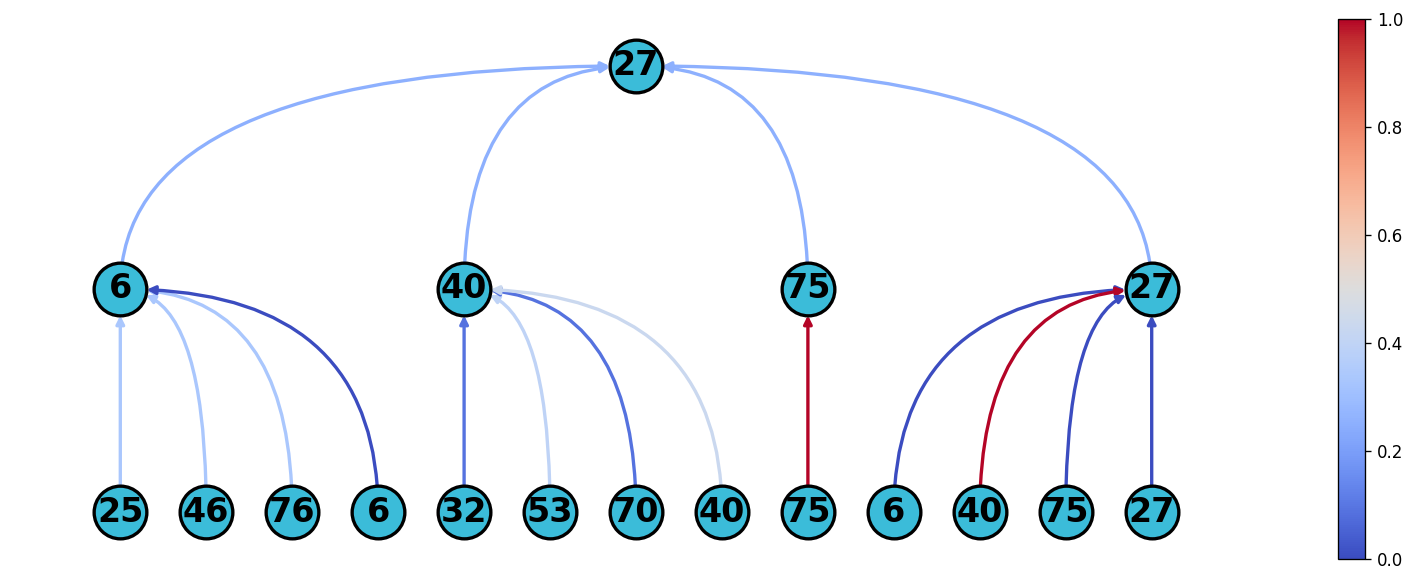

In [27]:
# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
)

from torch_geometric.utils import get_num_hops
from visualization_utils import (
    visualize_computation_graph,
    draw_local_comp_graph_with_ground_truth_path,
)
import torch

device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load("/workspace/Infection_dataset_small.pt").to(device)
# Load model as a whole
model = torch.load("/workspace/GAT_infection_small.pt").to(device)
model.eval()

target_idx = 27
num_layers = get_num_hops(model)

att_dict_raw = get_attention_raw_dict(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
)

Consider the case where we are interested in the attribution of edge 40 -> 27. We will implement three variants.

- ATTATTTRIBUTE: Attribution calculation from attention weights, as in the paper. 1) Find all cases where 40 -> 27 occurs in the computation graph. 2) For all cases, adjust the attention weights by the products of the attention weights that follow after the 40 -> 27 edge all the way to the root (no adjustment if there are no more edges left). 3) Sum up the adjusted attention weights.
- ATTATTTRIBUTE_SIM: Simpler versio of ATTATTENTIONM. The process is similar except that we do not adjust the attention edges, but simply sum up all occurences.
- AVGATTENTION: Average of all attention weights with respect to the layers for 40 -> 27.

#### ATTATTENTION code

In [3]:
# # First, get the list of all edges within the local k hop subgraph.
# # The logic will be similar with visualization_utils.darw_local_comp_graph_with_ground_truth_path
# from torch_geometric.utils import k_hop_subgraph

# target_idx = 27
# _, _, _, inv = k_hop_subgraph(
#     node_idx=target_idx,
#     num_hops=num_layers,
#     edge_index=data.edge_index,
#     relabel_nodes=True,
# )
# subgraph_edges = data.edge_index[:, inv].tolist()
# subgraph_edges = list(zip(subgraph_edges[0], subgraph_edges[1]))
# """
# subgraph_edges: [(6, 27),
# (25, 6),
# (32, 40),
# (40, 25),
# (40, 27),
# (46, 6),
# (53, 40),
# (70, 40),
# (75, 27),
# (76, 6)]
# """
# print(subgraph_edges)

[(6, 27), (25, 6), (32, 40), (40, 25), (40, 27), (46, 6), (53, 40), (70, 40), (75, 27), (76, 6)]


In [4]:
# # From subgraph_edges, we pick a target edge, let's say (40, 27)
# target_edge = (40, 27)

In [5]:
# """
# comp_graph: {0: tensor([[ 6, 40, 75, 27],
#         [27, 27, 27, 27]]),
# 1: tensor([[25, 46, 76,  6, 32, 53, 70, 40, 75,  6, 40, 75, 27],
#         [ 6,  6,  6,  6, 40, 40, 40, 40, 75, 27, 27, 27, 27]])}
# """
# print(comp_graph)

{0: tensor([[ 6, 40, 75, 27],
        [27, 27, 27, 27]]), 1: tensor([[25, 46, 76,  6, 32, 53, 70, 40, 75,  6, 40, 75, 27],
        [ 6,  6,  6,  6, 40, 40, 40, 40, 75, 27, 27, 27, 27]])}


In [6]:
# """
# comp_graph_new: {0: tensor([[1, 2, 3, 4],
#         [0, 0, 0, 0]]),
#  1: tensor([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
#         [ 1,  1,  1,  1,  2,  2,  2,  2,  3,  4,  4,  4,  4]])}
# """
# print(comp_graph_new)

{0: tensor([[1, 2, 3, 4],
        [0, 0, 0, 0]]), 1: tensor([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
        [ 1,  1,  1,  1,  2,  2,  2,  2,  3,  4,  4,  4,  4]])}


In [7]:
# # Pinpoint the target edge in the comp_graph
# # The target edge is (40, 27), which appears twice in the comp_graph
# # We want to find the index of the target edge in the comp_graph
# location_dict = {}

# for depth in comp_graph.items():
#     occurance_idx = []
#     for idx, edge in enumerate(depth[1].t().tolist()):
#         if edge == list(target_edge):
#             occurance_idx.append(idx)
#     location_dict[depth[0]] = occurance_idx

# print(location_dict)  # {0: [1], 1: [10]}

{0: [1], 1: [10]}


In [8]:
# # Use localtion_dict to retrieve all occurences of the target edge in the comp_graph_new in reinexed form
# # The target edge is (40, 27), which appears in location 1 in depth 0 and location 10 in depth 1
# # This translates to edge (2, 0) and edge (15, 4) in comp_graph_new, which is what we want
# # Output: {0: [(2, 0)], 1: [(15, 4)]}
# target_edge_new_dict = {}
# for depth in location_dict.items():
#     target_edge_new = []
#     for idx in depth[1]:
#         target_edge_new.append(tuple(comp_graph_new[depth[0]][:, idx].tolist()))
#     target_edge_new_dict[depth[0]] = target_edge_new

# print(target_edge_new_dict)  # {0: [(2, 0)], 1: [(15, 4)]}

{0: [(2, 0)], 1: [(15, 4)]}


In [9]:
# """
# layer_att_dict: {0: {(1, 0): 0.25, (2, 0): 0.25, (3, 0): 0.25, (4, 0): 0.25},
# 1: {(5, 1): 0.33303219079971313,
# (6, 1): 0.3333473801612854,
# (7, 1): 0.33350512385368347,
# (8, 1): 0.00011528600589372218,
# (9, 2): 0.08734562993049622,
# (10, 2): 0.39531180262565613,
# (11, 2): 0.08734562993049622,
# (12, 2): 0.42999687790870667,
# (13, 3): 1.0,
# (14, 4): 0.0003454849938862026,
# (15, 4): 0.9989635944366455,
# (16, 4): 0.0003454849938862026,
# (17, 4): 0.0003454849938862026}}
# """
# layer_att_dict

{0: {(1, 0): 0.25, (2, 0): 0.25, (3, 0): 0.25, (4, 0): 0.25},
 1: {(5, 1): 0.33303219079971313,
  (6, 1): 0.3333473801612854,
  (7, 1): 0.33350512385368347,
  (8, 1): 0.00011528600589372218,
  (9, 2): 0.08734562993049622,
  (10, 2): 0.39531180262565613,
  (11, 2): 0.08734562993049622,
  (12, 2): 0.42999687790870667,
  (13, 3): 1.0,
  (14, 4): 0.0003454849938862026,
  (15, 4): 0.9989635944366455,
  (16, 4): 0.0003454849938862026,
  (17, 4): 0.0003454849938862026}}

In [10]:
# # Now, for each edge in target_edge_new_dict, we want to find the corresponding attention value
# # We can do this by looking at layer_att_dict
# # Output: {(2, 0): 0.25, (15, 4): 0.9989635944366455}
# target_edge_att_dict = {}
# for depth in target_edge_new_dict.items():
#     for edge in depth[1]:
#         target_edge_att_dict[edge] = layer_att_dict[depth[0]][edge]

# print(target_edge_att_dict)  # {(2, 0): 0.25, (15, 4): 0.9989635944366455}

{(2, 0): 0.25, (15, 4): 0.9989635944366455}


In [11]:
# from typing import Dict, Tuple, List
# from torch import Tensor

# # If we return the sum of all the values in target_edge_att_dict, we get ATTATTTRIBUTE_sim.
# # To calculate ATTATTTRIBUTE, we need to check whether each edge has intermediate edges left
# # in the comp_graph_new to arrive to the root (node 0 in depth 0). If so, we need to multiply
# # the attention value of the edge with the attention value of the intermediate edge. Otherwise,
# # we just return the attention value of the edge.


# # First, we need to find the intermediate edges for each edge in target_edge_new_dict
# # Aim at devising a function that returns the intermediate edges for a given edge
# # Assuming we already know the depth of the edge in the comp_graph_new
# def return_intermediate_edges(
#     comp_graph_new: Dict[int, Tensor], edge: Tuple, depth: int
# ) -> List[Tuple]:
#     root_idx = 0
#     # If there are no intermediate edges, return [(-1, -1)]
#     if edge[1] == root_idx:
#         return [(-1, -1)]
#     # If there are intermediate edges, return a list of intermediate edges
#     intermediate_edges = []
#     curr_edge = edge
#     for curr_depth in range(depth - 1, -1, -1):
#         find_idx = curr_edge[1]
#         # Get the location where find_idx appear in comp_graph_new[curr_depth]
#         find_idx_location = comp_graph_new[curr_depth][0].tolist().index(find_idx)
#         curr_edge = tuple(comp_graph_new[curr_depth].t()[find_idx_location].tolist())
#         intermediate_edges.append(curr_edge)

#     return intermediate_edges

In [12]:
# # For each edge in target_edge_att_dict, find the intermediate edges and multiply their attention values
# # with the attention value of the edge in layer_att_dict
# # 0.9989635944366455 * 0.25 = 0.24974089860916138
# # Output: {(2, 0): 0.25, (15, 4): 0.24974089860916138}
# target_edge_att_dict_new = {}
# for depth, curr_edge_list in target_edge_new_dict.items():
#     for curr_edge in curr_edge_list:
#         # Find the intermediate edges for the current edge
#         intermediate_edges = return_intermediate_edges(comp_graph_new, curr_edge, depth)
#         # If intermediate_edges is [(-1, -1)], just return the original attention value
#         if intermediate_edges == [(-1, -1)]:
#             target_edge_att_dict_new[curr_edge] = target_edge_att_dict[curr_edge]
#         # Otherwise, multiply the attention value of the edge with the attention values of the intermediate edges
#         else:
#             curr_att = target_edge_att_dict[curr_edge]
#             curr_depth = depth - 1
#             for intermediate_edge in intermediate_edges:
#                 curr_att *= layer_att_dict[curr_depth][intermediate_edge]
#                 curr_depth -= 1
#             target_edge_att_dict_new[curr_edge] = curr_att

# print(target_edge_att_dict_new)  # {(2, 0): 0.25, (15, 4): 0.24974089860916138}

{(2, 0): 0.25, (15, 4): 0.24974089860916138}


In [13]:
# # Now let's make this into a function
# # Despite the name, this function returns all two ATTATTTRIBUTE, ATTATTTRIBUTE_sim
# def get_ATTATTTRIBUTE_edge(
#     comp_graph: Dict[int, Tensor],
#     comp_graph_new: Dict[int, Tensor],
#     layer_att_dict: Dict[int, Dict[Tuple, float]],
#     target_edge: Tuple[int, int],
#     verbose: bool = False,
# ) -> Tuple[float, float]:
#     # First, get location_dict
#     location_dict = {}
#     for depth in comp_graph.items():
#         occurance_idx = []
#         for idx, edge in enumerate(depth[1].t().tolist()):
#             if edge == list(target_edge):
#                 occurance_idx.append(idx)
#         location_dict[depth[0]] = occurance_idx

#     if verbose:
#         # Do not count the case where the value is [].
#         count = 0
#         for depth in location_dict.items():
#             if depth[1] != []:
#                 count += 1
#         print(f"Occurances of edge {target_edge}: {count}")

#     # Second, get target_edge_new_dict
#     target_edge_new_dict = {}
#     for depth in location_dict.items():
#         target_edge_new = []
#         for idx in depth[1]:
#             target_edge_new.append(tuple(comp_graph_new[depth[0]][:, idx].tolist()))
#         target_edge_new_dict[depth[0]] = target_edge_new

#     # Third, get target_edge_att_dict
#     target_edge_att_dict = {}
#     for depth in target_edge_new_dict.items():
#         for edge in depth[1]:
#             target_edge_att_dict[edge] = layer_att_dict[depth[0]][edge]

#     if verbose:
#         formatted_list = [
#             float("%.4f" % item) for item in list(target_edge_att_dict.values())
#         ]
#         print(
#             f"Naive attention for each occurance of edge {target_edge}: {formatted_list}"
#         )
#         print(
#             f"ATTATTRIBUTE_sim for edge {target_edge}: {sum(target_edge_att_dict.values()):.4f}"
#         )

#     # Fourth, get target_edge_att_dict_new
#     target_edge_att_dict_new = {}
#     for depth, curr_edge_list in target_edge_new_dict.items():
#         for curr_edge in curr_edge_list:
#             # Find the intermediate edges for the current edge
#             intermediate_edges = return_intermediate_edges(
#                 comp_graph_new, curr_edge, depth
#             )
#             # If intermediate_edges is [(-1, -1)], just return the original attention value
#             if intermediate_edges == [(-1, -1)]:
#                 target_edge_att_dict_new[curr_edge] = target_edge_att_dict[curr_edge]
#             # Otherwise, multiply the attention value of the edge with the attention values of the intermediate edges
#             else:
#                 curr_att = target_edge_att_dict[curr_edge]
#                 curr_depth = depth - 1
#                 for intermediate_edge in intermediate_edges:
#                     curr_att *= layer_att_dict[curr_depth][intermediate_edge]
#                     curr_depth -= 1
#                 target_edge_att_dict_new[curr_edge] = curr_att

#     if verbose:
#         print(
#             f"ATTATTTRIBUTE for edge {target_edge}: {sum(target_edge_att_dict_new.values()):.4f}"
#         )

#     # Fifth, return the sum of all the values in target_edge_att_dict_new
#     return sum(target_edge_att_dict_new.values()), sum(target_edge_att_dict.values())

In [28]:
# # Test the function
# target_edge = (40, 27)

# get_ATTATTTRIBUTE_edge(
#     comp_graph=comp_graph,
#     comp_graph_new=comp_graph_new,
#     layer_att_dict=layer_att_dict,
#     target_edge=target_edge,
#     verbose=True,
# )  # 0.24974089860916138

Occurances of edge (40, 27): 2
Naive attention for each occurance of edge (40, 27): [0.25, 0.999]
ATTATTRIBUTE_sim for edge (40, 27): 1.2490
ATTATTTRIBUTE for edge (40, 27): 0.4997


(0.4997408986091614, 1.2489635944366455)

In [15]:
# # Finally, make a function that just naively averages the attention for each layer (AVGATT)
# # We just directly use the model.att to get the result

# # att: List of lists
# # att[0]: [edge_index, att_weight] for layer 0
# # att[1]: [edge_index, att_weight] for layer 1

# att = model.att

In [ ]:
# def get_AVGATT(att: List, edge: Tuple[int]) -> float:
#     # First, get the index of the edge in each edge_index in att
#     att_list = []
#     for curr_att in att:
#         for idx, curr_edge in enumerate(list(zip(curr_att[0][0], curr_att[0][1]))):
#             if curr_edge == edge:
#                 att_list.append(idx)
#                 break

#     # Then, get the attention value of the edge in each edge_index in att
#     att_value_list = []
#     for layer, curr_att in enumerate(att):
#         att_value_list.append(curr_att[1][att_list[layer]].item())


#     # Calculate the average attention value of the edge in all edge_index in att
#     return sum(att_value_list) / len(att_value_list)

In [ ]:
# get_AVGATT(att=att, edge=(40, 27))

#### Check if code runs correctly

In [30]:
# # Import the utility functions
# from attention_analysis_utils import (
#     get_attention_raw_dict,
#     process_attention_dict,
#     get_computation_graph,
#     get_nodes_per_level_from_comp_graph_full,
#     reindex_nodes_per_level,
#     translate_comp_graph,
#     get_att_dict_per_layer,
#     get_ATTATTTRIBUTE_edge,
#     get_AVGATT_edge,
# )

# from torch_geometric.utils import get_num_hops
# from visualization_utils import (
#     visualize_computation_graph,
#     draw_local_comp_graph_with_ground_truth_path,
# )
# import torch

# device = torch.device("cpu")
# # Load the network data locally (for reproduction)
# data = torch.load("/workspace/Infection_dataset_small.pt").to(device)
# # Load model as a whole
# model = torch.load("/workspace/GAT_infection_small.pt").to(device)
# model.eval()

GAT_L2(
  (conv1): GATConv(2, 8, heads=1)
  (conv2): GATConv(8, 5, heads=1)
)

In [32]:
# target_idx = 27
# num_layers = get_num_hops(model)

# att_dict_raw = get_attention_raw_dict(model, data)
# att_dict = process_attention_dict(att_dict_raw)
# comp_graph = get_computation_graph(
#     edge_index=data.edge_index, k=num_layers, target_idx=target_idx
# )
# (
#     nodes_per_level_original,
#     num_nodes_per_level,
#     true_node_label,
# ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
# nodes_per_level_new = reindex_nodes_per_level(
#     nodes_per_level_original, num_nodes_per_level
# )
# comp_graph_new = translate_comp_graph(
#     comp_graph=comp_graph,
#     nodes_per_level_new=nodes_per_level_new,
#     nodes_per_level_original=nodes_per_level_original,
# )
# layer_att_dict = get_att_dict_per_layer(
#     comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
# )

In [33]:
# get_ATTATTTRIBUTE_edge(
#     comp_graph=comp_graph,
#     comp_graph_new=comp_graph_new,
#     layer_att_dict=layer_att_dict,
#     target_edge=(40, 27),
#     verbose=False,
# )

(0.4997408986091614, 1.2489635944366455)

In [34]:
# with torch.no_grad():
#     model(data.x, data.edge_index, return_att=True)
#     att = model.att
# get_AVGATT_edge(att=att, edge=(40, 27))

0.6244817972183228

#### Now, we make tools to force attention to zero during GATConv

In [1]:
# import torch
# from models import GAT_L2_intervention
# from attention_analysis_utils import get_ATTATTTRIBUTE_edge, get_AVGATT_edge

# device = torch.device("cpu")
# # Load the network data locally (for reproduction)
# data = torch.load("/workspace/Infection_dataset_small.pt").to(device)
# # Load model as a whole
# model = torch.load("/workspace/GAT_infection_small.pt").to(device)
# model.eval()

GAT_L2(
  (conv1): GATConv(2, 8, heads=1)
  (conv2): GATConv(8, 5, heads=1)
)

In [2]:
# model_intervention = GAT_L2_intervention(
#     in_channels=2, hidden_channels=8, out_channels=5, heads=1, dropout=0
# )

# # Copy model parameters from model to model_intervention
# model_intervention.load_state_dict(model.state_dict())

<All keys matched successfully>

In [3]:
# # Test if whether we can successfully feed forward with masking an edge
# mask_edge = (40, 27)

# # Output without any masking
# with torch.no_grad():
#     output = model_intervention(x = data.x,
#                                     edge_index = data.edge_index,
#                                     return_att = True,
#                                     mask_edge = None)
#     att = model.att
#     pred = output.argmax(dim=1)
#     correct = pred.eq(data.y).sum().item()
#     acc = correct / data.num_nodes
#     print(f'Accuracy: {acc:.4f}')

# # Output with masking
# with torch.no_grad():
#     output_masked = model_intervention(x = data.x,
#                                                 edge_index = data.edge_index,
#                                                 return_att = True,
#                                                 mask_edge = mask_edge)
#     att_masked = model.att
#     pred_masked = output_masked.argmax(dim=1)
#     correct_masked = pred_masked.eq(data.y).sum().item()
#     acc_masked = correct_masked / data.num_nodes
#     print(f'Accuracy: {acc_masked:.4f}')

Accuracy: 0.7000
Accuracy: 0.6875


In [4]:
# # Compare the output of target node
# target_idx = 27

# print(f"Target node: {target_idx}")
# print(f"Target node's label: {data.y[target_idx].item()}")
# prediction = pred[target_idx].item()
# print(f"Target node's prediction: {prediction}")
# prob_vector = output[target_idx].softmax(dim=0)
# print(f"Target node's prediction probability: {prob_vector[prediction].item():.4f}")
# # Also measure the negative entropy of the prediction vector
# entropy = - (prob_vector * prob_vector.log()).sum().item()
# print(f"Target node's prediction entropy: {entropy:.4f}")

# print(f"After masking edge {mask_edge}")
# print(f"Target node's prediction: {pred_masked[target_idx].item()}")
# prob_vector_masked = output_masked[target_idx].softmax(dim=0)
# print(f"Target node's prediction probability: {prob_vector_masked[prediction].item():.4f}")
# # Also measure the negative entropy of the prediction vector
# entropy_masked = - (prob_vector_masked * prob_vector_masked.log()).sum().item()
# print(f"Target node's prediction entropy: {entropy_masked:.4f}")

Target node: 27
Target node's label: 2
Target node's prediction: 2
Target node's prediction probability: 0.9816
Target node's prediction entropy: 0.0945
After masking edge (40, 27)
Target node's prediction: 1
Target node's prediction probability: 0.0804
Target node's prediction entropy: 1.2546


In [1]:
# Now, we have everything that we need to run the experiment on a single target node.
# The experiment is run as follows.
# 1. We select a target node (given as a parameter to the function)
# 2. Get all edges within the target node's k-hop neighborhood
# 3. For all edges in the k-hop neighborhood, we get the attribution scores
# according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
# 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
# 5. Now, we mask each edge acquired in step 2, and get the 1) label 2) prediction 3) prediction probability 4) entropy values
# by masking the edge.
# 6. Compare the importance ranking between the three scores in step 3 and the change in the values in step 5.
# Just do this for one target node for now.

# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)

from torch_geometric.utils import get_num_hops, get_num_hops

from typing import Tuple

import torch
from models import GAT_L2_intervention
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)
from torch_geometric.utils import get_num_hops
from typing import Tuple
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


def get_edge_scores(
    target_edge: Tuple, comp_graph, comp_graph_new, layer_att_dict, att
):
    assert type(target_edge) == tuple, "target_edge must be a tuple"
    # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
    attattribute, attattribute_sim = get_ATTATTTRIBUTE_edge(
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        target_edge=target_edge,
        verbose=False,
    )
    # Get AVGATT scores
    avgatt = get_AVGATT_edge(att=att, edge=target_edge)

    return attattribute, attattribute_sim, avgatt


# def get_edge_scores(target_edge: Tuple, comp_graph, comp_graph_new, layer_att_dict):
#     assert type(target_edge) == tuple, "target_edge must be a tuple"
#     # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
#     attattribute, attattribute_sim = get_ATTATTTRIBUTE_edge(
#         comp_graph=comp_graph,
#         comp_graph_new=comp_graph_new,
#         layer_att_dict=layer_att_dict,
#         target_edge=target_edge,
#         verbose=False,
#     )
#     # Get AVGATT scores
#     avgatt = get_AVGATT_edge(att=att, edge=target_edge)

#     return attattribute, attattribute_sim, avgatt


# Let's refactor tha code below as a function
def experiment_on_target_node(
    target_idx: int, data, model, self_loops=True, verbose=False
):
    # 1. Get the number of hops according to the model
    num_hops = get_num_hops(model)
    # 2. Get all edges within the target node's k-hop neighborhood
    edge_lists = return_edges_in_k_hop(
        data=data, target_idx=target_idx, hop=2, self_loops=self_loops
    )
    if verbose:
        print(f"Number of edges in the k-hop neighborhood: {len(edge_lists)}")

    # 3. For all edges in the k-hop neighborhood, we get the attribution scores
    # according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
    # First, prepare ingredients for analysis

    num_layers = get_num_hops(model)
    att_dict_raw = get_attention_raw_dict(model, data)
    att_dict = process_attention_dict(att_dict_raw)
    comp_graph = get_computation_graph(
        edge_index=data.edge_index, k=num_layers, target_idx=target_idx
    )
    (
        nodes_per_level_original,
        num_nodes_per_level,
        true_node_label,
    ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
    nodes_per_level_new = reindex_nodes_per_level(
        nodes_per_level_original, num_nodes_per_level
    )
    comp_graph_new = translate_comp_graph(
        comp_graph=comp_graph,
        nodes_per_level_new=nodes_per_level_new,
        nodes_per_level_original=nodes_per_level_original,
    )
    layer_att_dict = get_att_dict_per_layer(
        comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
    )

    # 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
    # Output without any masking
    with torch.no_grad():
        output = model(
            x=data.x, edge_index=data.edge_index, return_att=True, mask_edge=None
        )
        att = model.att
        pred = output.argmax(dim=1)[target_idx].item()  # Single integer
        pred_prob = output[target_idx].softmax(dim=0)[pred].item()  # Single float
        prob_vector = output[target_idx].softmax(dim=0)  # 1D vector of floats
        entropy = -(prob_vector * prob_vector.log()).sum().item()  # Single float
    # Get results for all edges in the k-hop neighborhood
    attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
    for current_edge in edge_lists:
        attattribute, attattribute_sim, avgatt = get_edge_scores(
            target_edge=tuple(current_edge),
            comp_graph=comp_graph,
            comp_graph_new=comp_graph_new,
            layer_att_dict=layer_att_dict,
            att=att,
        )
        attattribute_list.append(attattribute)
        attattribute_sim_list.append(attattribute_sim)
        avgatt_list.append(avgatt)
        if verbose:
            print(
                f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), ATTATTRIBUTE: {attattribute:.4f}, ATTATTRIBUTE_sim: {attattribute_sim:.4f}, AVGATT: {avgatt:.4f}"
            )

    # 5. Now, we mask each edge acquired in step 2, and get the 1) label 2) prediction 3) prediction probability 4) entropy values
    # by masking the edge.
    # Output with masking
    pred_list_masked, pred_prob_list_masked, entropy_list_masked = [], [], []
    for current_edge in edge_lists:
        with torch.no_grad():
            output_masked = model(
                x=data.x,
                edge_index=data.edge_index,
                return_att=True,
                mask_edge=current_edge,
            )
            att_masked = model.att
            pred_masked = output_masked.argmax(dim=1)[target_idx].item()
            pred_prob_masked = (
                output_masked[target_idx].softmax(dim=0)[pred_masked].item()
            )
            prob_vector_masked = output_masked[target_idx].softmax(dim=0)
            entropy_masked = (
                -(prob_vector_masked * prob_vector_masked.log()).sum().item()
            )
        pred_list_masked.append(pred_masked)
        pred_prob_list_masked.append(pred_prob_masked)
        entropy_list_masked.append(entropy_masked)
        if verbose:
            print(
                f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), prediction: {pred:1d} → {pred_masked:1d}, Δpred_prob: {pred_prob - pred_prob_masked:.4f}, Δentropy: {entropy - entropy_masked:.4f}"
            )
    # For pred_list_masked, change into a list of bools indicating whether the prediction has changed
    # Compare pred_list_masked with
    pred_list_masked_bool = [pred != curr_pred for curr_pred in pred_list_masked]
    # For pred_prob_list_masked, change into a list of floats indicating the change in prediction probability
    pred_prob_list_masked_float = [
        pred_prob - curr_pred_prob for curr_pred_prob in pred_prob_list_masked
    ]
    # For entropy_list_masked, change into a list of floats indicating the change in entropy
    entropy_list_masked_float = [
        curr_entropy - entropy for curr_entropy in entropy_list_masked
    ]

    return (
        attattribute_list,
        attattribute_sim_list,
        avgatt_list,
        pred_list_masked_bool,
        pred_prob_list_masked_float,
        entropy_list_masked_float,
    )

In [117]:
# # Run and stack the results of the experiment for all nodes in data.unique_solution_nodes

# attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
# pred_list_masked_bool, pred_prob_list_masked_float, entropy_list_masked_float = (
#     [],
#     [],
#     [],
# )
# for target_node in data.unique_solution_nodes:
#     target_node_results = experiment_on_target_node(
#         target_idx=target_node,
#         data=data,
#         model=model,
#     )
#     attattribute_list_curr = target_node_results[0]
#     attattribute_sim_list_curr = target_node_results[1]
#     avgatt_list_curr = target_node_results[2]
#     pred_list_masked_bool_curr = target_node_results[3]
#     pred_prob_list_masked_float_curr = target_node_results[4]
#     entropy_list_masked_float_curr = target_node_results[5]

#     attattribute_list.extend(attattribute_list_curr)
#     attattribute_sim_list.extend(attattribute_sim_list_curr)
#     avgatt_list.extend(avgatt_list_curr)
#     pred_list_masked_bool.extend(pred_list_masked_bool_curr)
#     pred_prob_list_masked_float.extend(pred_prob_list_masked_float_curr)
#     entropy_list_masked_float.extend(entropy_list_masked_float_curr)

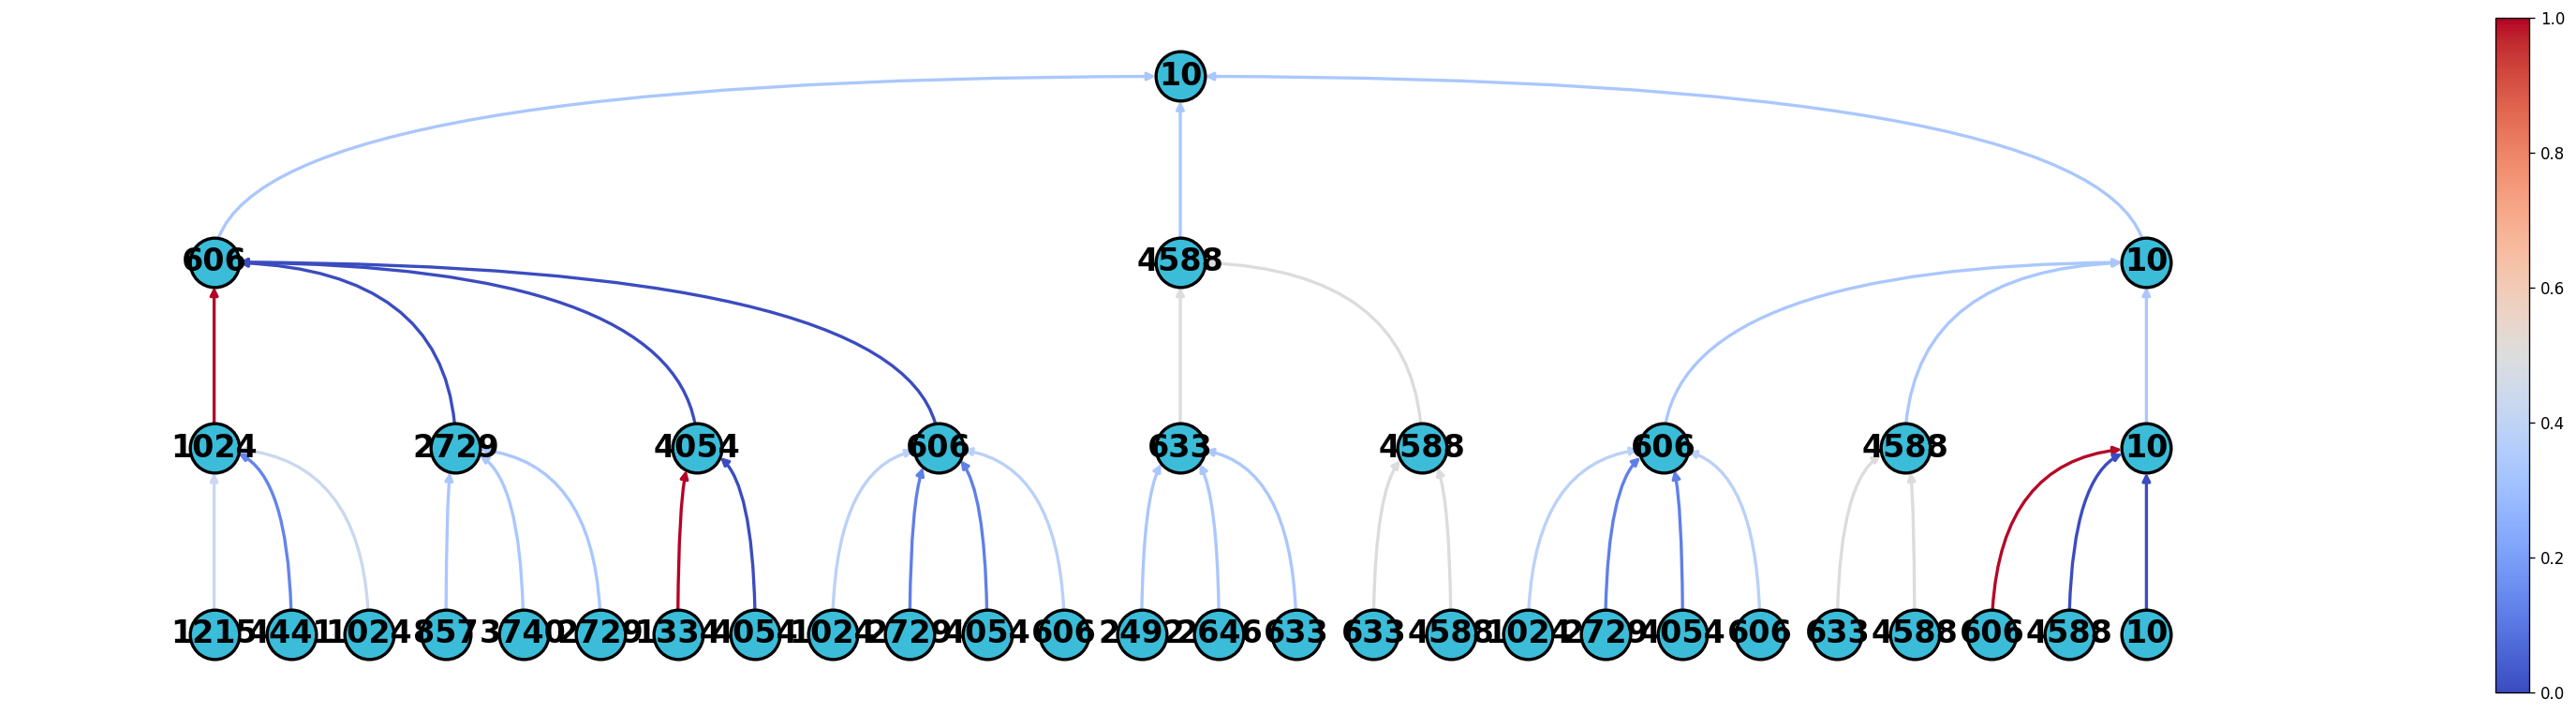

In [42]:
# # Import the utility functions
# from attention_analysis_utils import (
#     get_attention_raw_dict,
#     process_attention_dict,
#     get_computation_graph,
#     get_nodes_per_level_from_comp_graph_full,
#     reindex_nodes_per_level,
#     translate_comp_graph,
#     get_att_dict_per_layer,
# )

# from torch_geometric.utils import get_num_hops
# from visualization_utils import (
#     visualize_computation_graph,
#     draw_local_comp_graph_with_ground_truth_path,
# )

# target_idx = 10
# num_layers = get_num_hops(model)

# att_dict_raw = get_attention_raw_dict(model, data)
# att_dict = process_attention_dict(att_dict_raw)
# comp_graph = get_computation_graph(
#     edge_index=data.edge_index, k=num_layers, target_idx=target_idx
# )
# (
#     nodes_per_level_original,
#     num_nodes_per_level,
#     true_node_label,
# ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
# nodes_per_level_new = reindex_nodes_per_level(
#     nodes_per_level_original, num_nodes_per_level
# )
# comp_graph_new = translate_comp_graph(
#     comp_graph=comp_graph,
#     nodes_per_level_new=nodes_per_level_new,
#     nodes_per_level_original=nodes_per_level_original,
# )
# layer_att_dict = get_att_dict_per_layer(
#     comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
# )
# visualize_computation_graph(
#     layer_att_dict=layer_att_dict,
#     nodes_per_level_new=nodes_per_level_new,
#     true_node_label=true_node_label,
# )

#### Code for runnint experiments (do not run these cell unless re-experimenting)

In [ ]:
# # Run and stack the results of the experiment for all nodes in data.unique_solution_nodes

# attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
# pred_list_masked_bool, pred_prob_list_masked_float, entropy_list_masked_float = (
#     [],
#     [],
#     [],
# )
# for target_node in data.unique_solution_nodes:
#     target_node_results = experiment_on_target_node(
#         target_idx=target_node,
#         data=data,
#         model=model,
#         self_loops=True,
#         verbose=False,
#     )
#     attattribute_list_curr = target_node_results[0]
#     attattribute_sim_list_curr = target_node_results[1]
#     avgatt_list_curr = target_node_results[2]
#     pred_list_masked_bool_curr = target_node_results[3]
#     pred_prob_list_masked_float_curr = target_node_results[4]
#     entropy_list_masked_float_curr = target_node_results[5]

#     attattribute_list.extend(attattribute_list_curr)
#     attattribute_sim_list.extend(attattribute_sim_list_curr)
#     avgatt_list.extend(avgatt_list_curr)
#     pred_list_masked_bool.extend(pred_list_masked_bool_curr)
#     pred_prob_list_masked_float.extend(pred_prob_list_masked_float_curr)
#     entropy_list_masked_float.extend(entropy_list_masked_float_curr)

In [ ]:
# torch.save(
#     torch.Tensor(attattribute_list),
#     f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt",
# )
# torch.save(
#     torch.Tensor(attattribute_sim_list),
#     f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt",
# )
# torch.save(
#     torch.Tensor(avgatt_list), f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt"
# )
# torch.save(
#     torch.Tensor(pred_list_masked_bool),
#     f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt",
# )
# torch.save(
#     torch.Tensor(pred_prob_list_masked_float),
#     f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt",
# )
# torch.save(
#     torch.Tensor(entropy_list_masked_float),
#     f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt",
# )

#### Now for the bigger infection dataset

Perform the same experiment but with the bigger infection dataset: Infection_50002d_sp.pt

Now with the Infection_50003d_sp.pt

In [2]:
import torch

dataset_name = "Infection_50003d_sp"
model_name = "GAT_infection_3L1H_sp"

device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load(f"/workspace/{dataset_name}.pt").to(device)
# Load the trained model locally (for reproduction)
model = torch.load(f"/workspace/{model_name}.pt").to(device)
model.eval()

with torch.no_grad():
    att = model.att

# Load experiments from local

attattribute_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt"
)
attattribute_sim_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt"
)
avgatt_list = torch.load(f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt")
pred_list_masked_bool = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt"
)
pred_prob_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt"
)
entropy_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt"
)

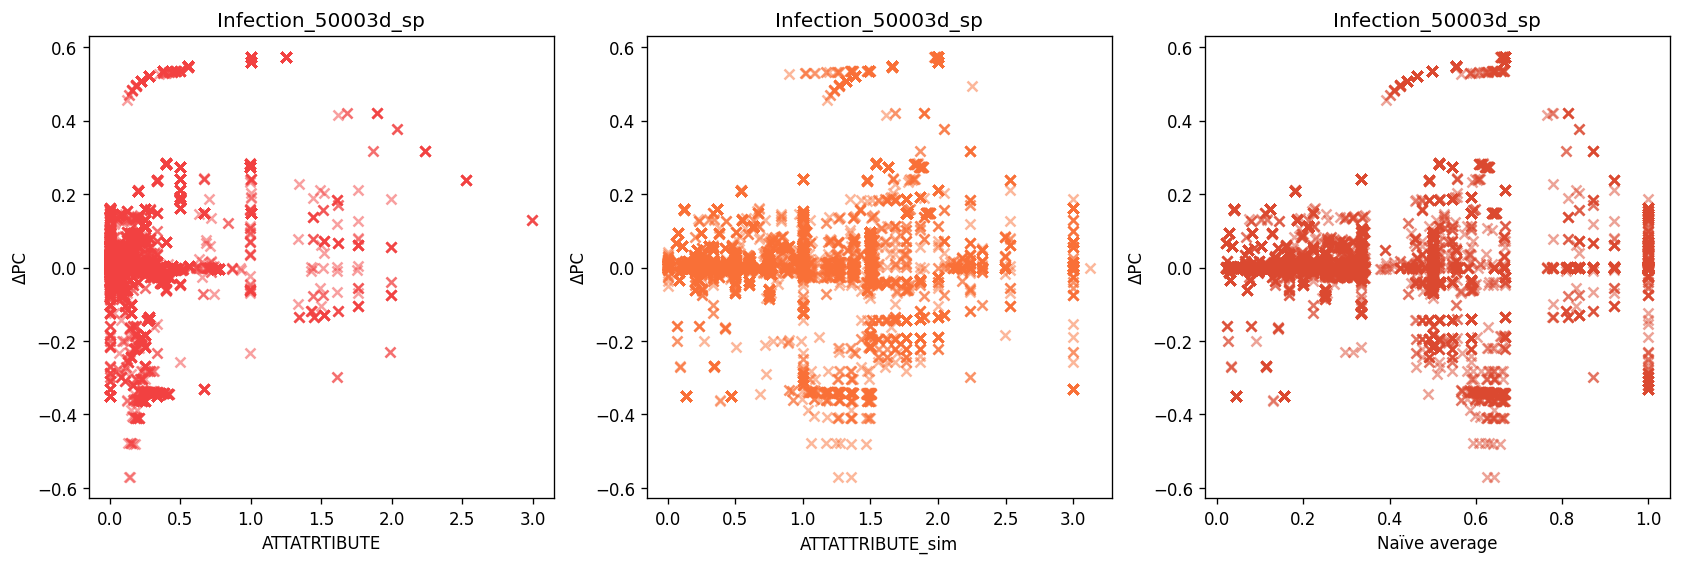

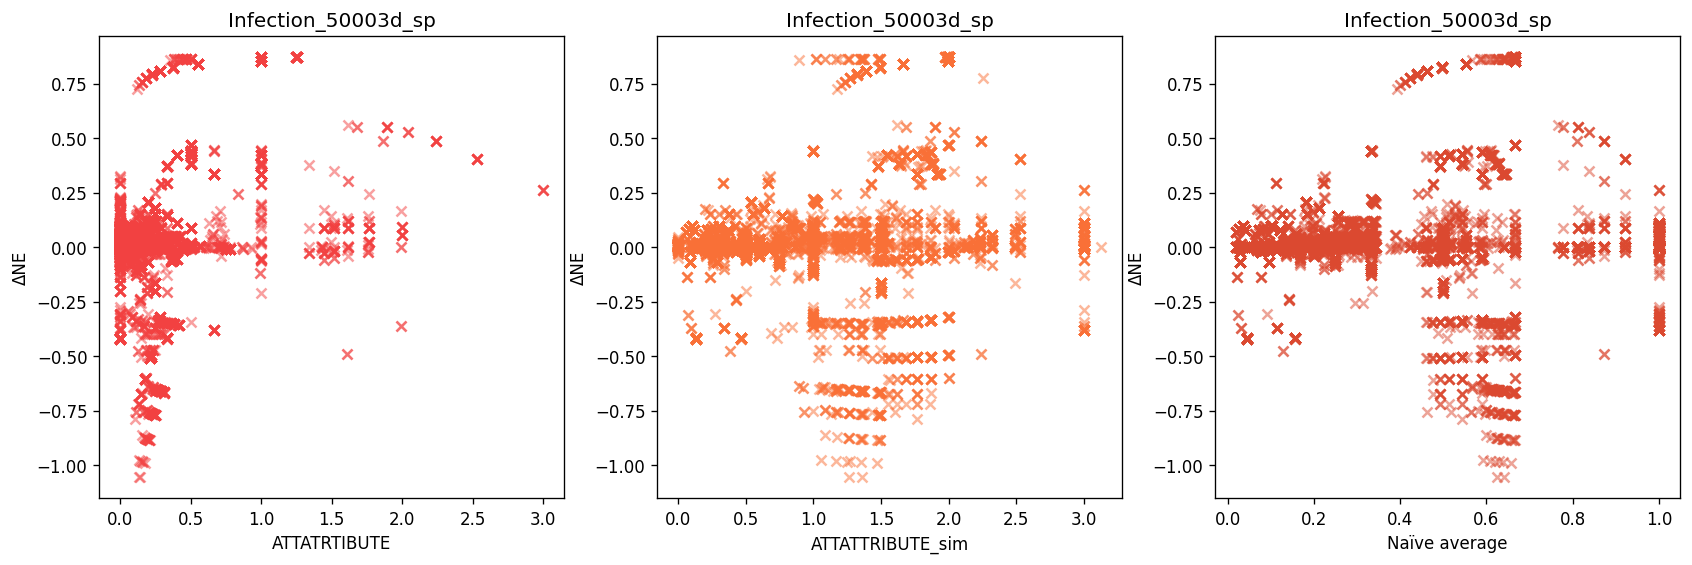

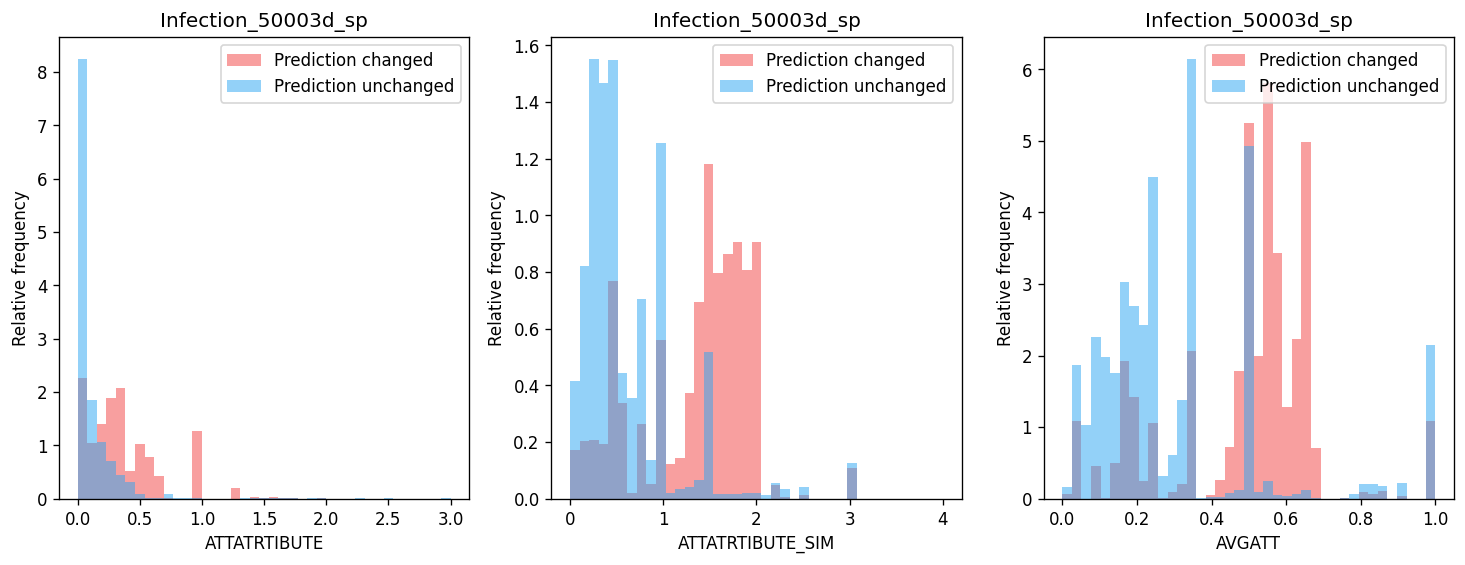

In [92]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Flag to whether print statistics in the figure
PRINT_CORRELATION_COEFFICIENT = False

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
# Scatter plot with alpha=0.5, color #f24141
axs[0].scatter(
    attattribute_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, pred_prob_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #F97037
axs[1].scatter(
    attattribute_sim_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, pred_prob_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #DB4930
axs[2].scatter(
    avgatt_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, pred_prob_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Plot a similar graph but use entropy instead of prediction difference
# Set the figure size to (17, 5)
# Also show the correlation coefficient for each cases inside the corresponding subplot

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
axs[0].scatter(
    attattribute_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, entropy_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[1].scatter(
    attattribute_sim_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, entropy_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[2].scatter(
    avgatt_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, entropy_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Also, plot the data in pred_list_masked_bool (list of 0 and 1s) as a histogram
# For example, we can divide attattribute_list into two groups:
# 1. pred_list_masked_bool = 1
# 2. pred_list_masked_bool = 0
# Then, we can plot the histogram of the two groups in the same plot
# Adjust the alpha value to make the two histograms distinguishable
# The x-axis is the attribute value, and the y-axis is the frequency
# The title of the plot is still the dataset name
# Like above, we can also plot the histogram of the two groups in the same plot
# Do it for all three attattribute_list, attattribute_sim_list, and avgatt_list

# First get the max value of the three lists
max_attattribute_list = max(attattribute_list).ceil()
max_attattribute_sim_list = max(attattribute_sim_list).ceil()
max_avgatt_list = max(avgatt_list).ceil()

# Make two masking tensors from pred_list_masked_bool that are complementary
mask_remained = torch.logical_not(pred_list_masked_bool)
mask_flipped = pred_list_masked_bool.bool()

# Make the bins used for the histogram
bins_attattribute = torch.linspace(0, max_attattribute_list, 40)
bins_attattribute_sim = torch.linspace(0, max_attattribute_sim_list, 40)
bins_avgatt = torch.linspace(0, max_avgatt_list, 40)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
axs[0].hist(attattribute_list[mask_flipped], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#F24141",
            label='Prediction changed')
axs[0].hist(attattribute_list[mask_remained], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#29A5F2",
            label='Prediction unchanged')
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("Relative frequency")

axs[1].hist(attattribute_sim_list[mask_flipped], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[1].hist(attattribute_sim_list[mask_remained], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATRTIBUTE_SIM")
axs[1].set_ylabel("Relative frequency")

axs[2].hist(avgatt_list[mask_flipped], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[2].hist(avgatt_list[mask_remained], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("AVGATT")
axs[2].set_ylabel("Relative frequency")

# Add the legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

In [3]:
# Statistical testing with Kendall's Tau and Spearman's Rho, Pearson's Rho
# Also include the ROC AUC score between each attribution and the decision change in pred_list_masked_bool
# Kendall's Tau is a non-parametric test for the strength of association between two variables
# Spearman's Rho is a non-parametric test for the strength of monotonic association between two variables
from scipy.stats import kendalltau, spearmanr, pearsonr
from sklearn.metrics import roc_auc_score

"""
    Compare...
    1. pred_prob_list_masked_float vs. attattribute_list
    2. pred_prob_list_masked_float vs. attattribute_sim_list
    3. pred_prob_list_masked_float vs. avgatt_list
    4. entropy_list_masked_float vs. attattribute_list
    5. entropy_list_masked_float vs. attattribute_sim_list
    6. entropy_list_masked_float vs. avgatt_list
    7. ROC AUC score between each attribution and the decision change in pred_list_masked_bool
"""
# Also include a random baseline
random_attr = torch.rand(pred_prob_list_masked_float.shape)

random_attr_kendall = kendalltau(pred_prob_list_masked_float, random_attr)
random_attr_spearman = spearmanr(pred_prob_list_masked_float, random_attr)
random_attr_pearson = pearsonr(pred_prob_list_masked_float, random_attr)
random_attr_roc_auc = roc_auc_score(pred_list_masked_bool, random_attr)

# Print results
print("RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{random_attr_kendall[0]:.4f}, {random_attr_spearman[0]:.4f}, {random_attr_pearson[0]:.4f}")
print("RANDOM vs. Δprob: ROC AUC")
print(f"{random_attr_roc_auc:.4f}")


attattribute_prob_kendall = kendalltau(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_spearman = spearmanr(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_pearson = pearsonr(pred_prob_list_masked_float, attattribute_list)

attattribute_sim_prob_kendall = kendalltau(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_spearman = spearmanr(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_pearson = pearsonr(
    pred_prob_list_masked_float, attattribute_sim_list
)

avgatt_prob_kendall = kendalltau(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_spearman = spearmanr(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_pearson = pearsonr(pred_prob_list_masked_float, avgatt_list)

attattribute_entropy_kendall = kendalltau(entropy_list_masked_float, attattribute_list)
attattribute_entropy_spearman = spearmanr(entropy_list_masked_float, attattribute_list)
attattribute_entropy_pearson = pearsonr(entropy_list_masked_float, attattribute_list)

attattribute_sim_entropy_kendall = kendalltau(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_spearman = spearmanr(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_pearson = pearsonr(
    entropy_list_masked_float, attattribute_sim_list
)

avgatt_entropy_kendall = kendalltau(entropy_list_masked_float, avgatt_list)
avgatt_entropy_spearman = spearmanr(entropy_list_masked_float, avgatt_list)
avgatt_entropy_pearson = pearsonr(entropy_list_masked_float, avgatt_list)


attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list / attattribute_list.max())
attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list / attattribute_sim_list.max())
# attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list)
# attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list)
avgatt_roc_auc = roc_auc_score(pred_list_masked_bool, avgatt_list)

# Print results
print("ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_prob_kendall[0]:.4f}, {attattribute_prob_spearman[0]:.4f}, {attattribute_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_prob_kendall[0]:.4f}, {attattribute_sim_prob_spearman[0]:.4f}, {attattribute_sim_prob_pearson[0]:.4f}")
print("AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_prob_kendall[0]:.4f}, {avgatt_prob_spearman[0]:.4f}, {avgatt_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_entropy_kendall[0]:.4f}, {attattribute_entropy_spearman[0]:.4f}, {attattribute_entropy_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_entropy_kendall[0]:.4f}, {attattribute_sim_entropy_spearman[0]:.4f}, {attattribute_sim_entropy_pearson[0]:.4f}")
print("AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_entropy_kendall[0]:.4f}, {avgatt_entropy_spearman[0]:.4f}, {avgatt_entropy_pearson[0]:.4f}")
print("ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT")
print(f"{attattribute_roc_auc:.4f}, {attattribute_sim_roc_auc:.4f}, {avgatt_roc_auc:.4f}")

RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0034, 0.0050, 0.0080
RANDOM vs. Δprob: ROC AUC
0.5151
ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
-0.1073, -0.1290, 0.3478
ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
-0.0247, -0.0188, 0.2290
AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0265, 0.0392, 0.1090
ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
-0.0658, -0.0833, 0.3665
ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0142, 0.0379, 0.2263
AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0461, 0.0644, 0.1062
ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT
0.8065, 0.8223, 0.7651


Now for Infection_50002d_sp.pt

In [4]:
import torch

dataset_name = "Infection_50002d_sp"
model_name = "GAT_infection_2L1H_sp"

device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load(f"/workspace/{dataset_name}.pt").to(device)
# Load the trained model locally (for reproduction)
model = torch.load(f"/workspace/{model_name}.pt").to(device)
model.eval()

with torch.no_grad():
    att = model.att

# Load experiments from local

attattribute_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt"
)
attattribute_sim_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt"
)
avgatt_list = torch.load(f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt")
pred_list_masked_bool = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt"
)
pred_prob_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt"
)
entropy_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt"
)

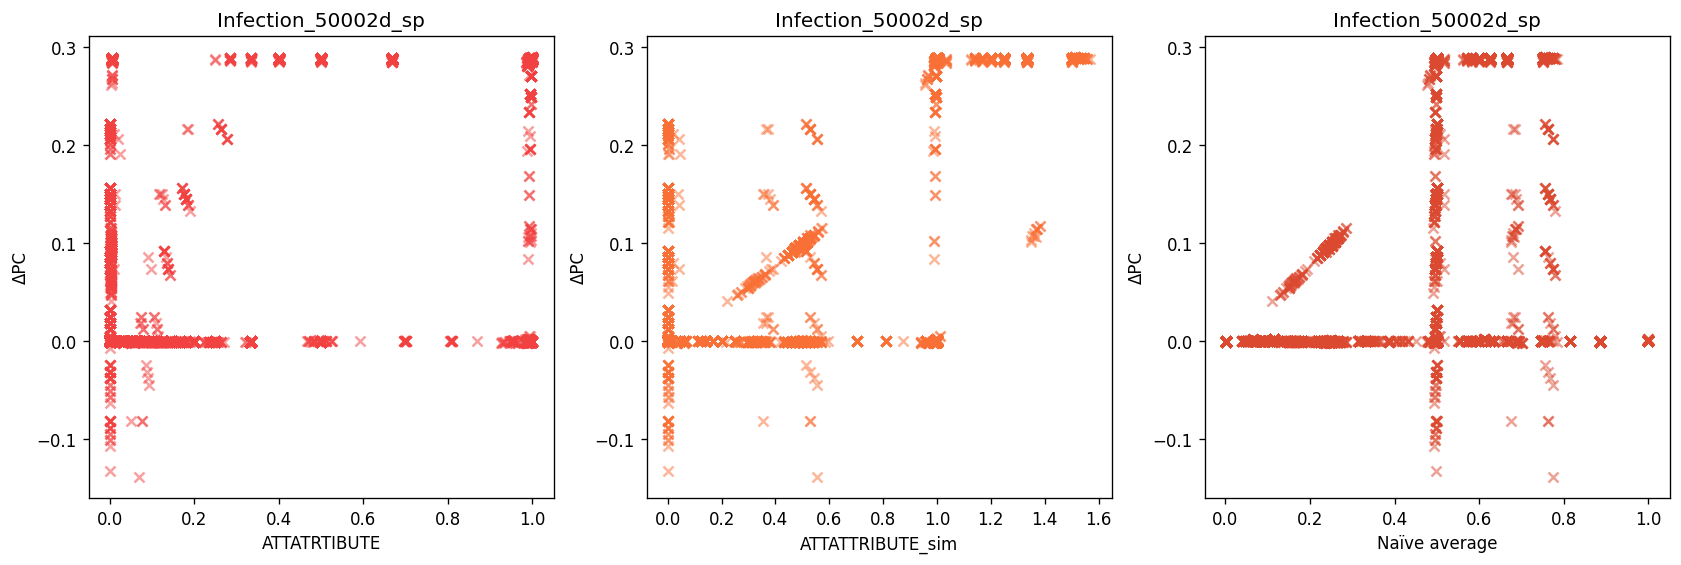

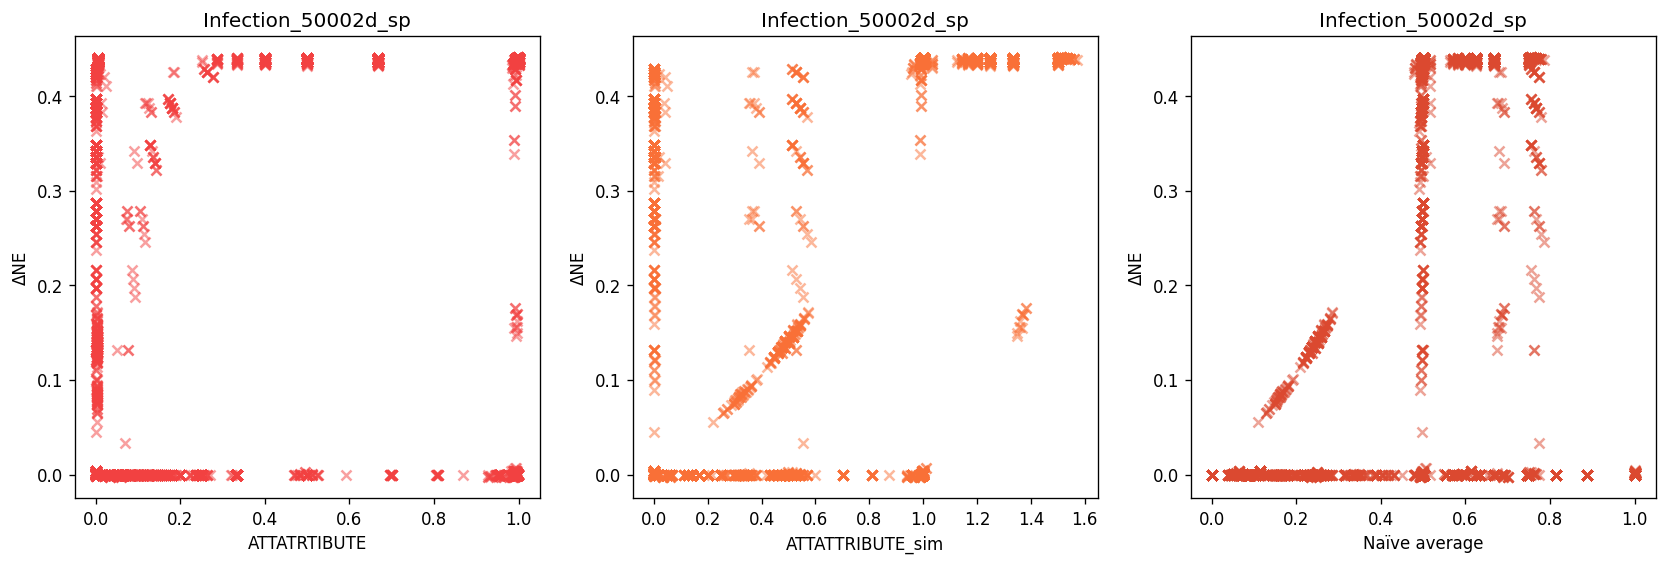

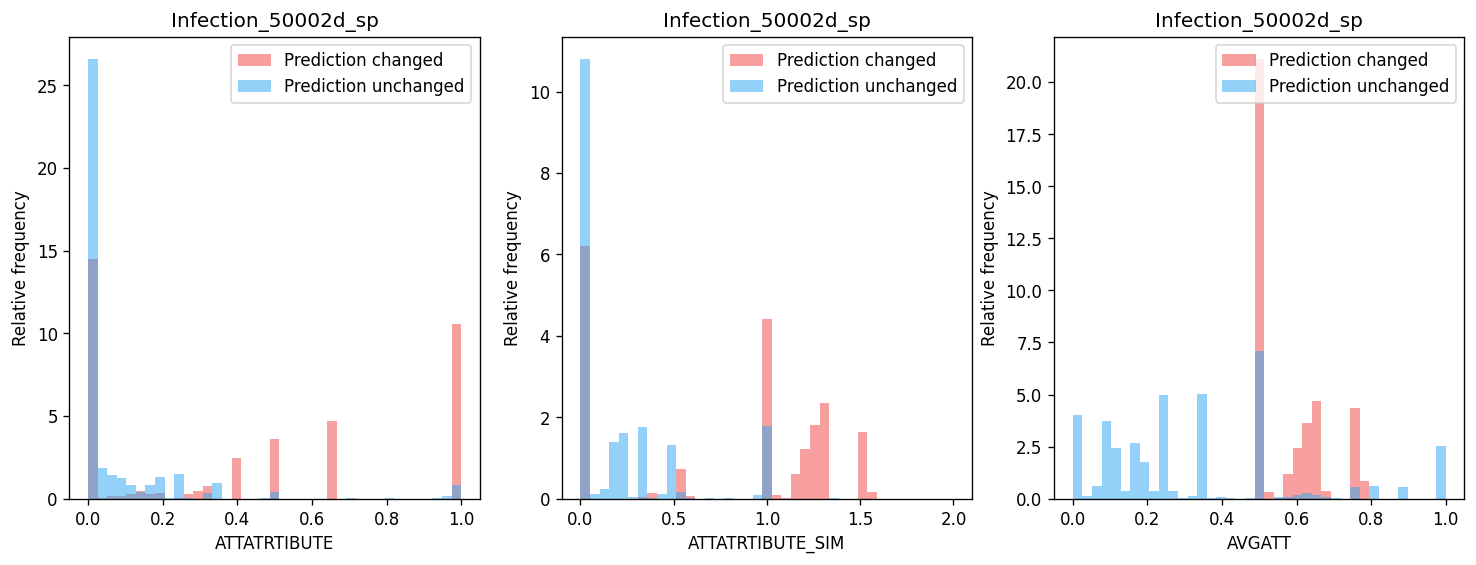

In [96]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Flag to whether print statistics in the figure
PRINT_CORRELATION_COEFFICIENT = False

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
# Scatter plot with alpha=0.5, color #f24141
axs[0].scatter(
    attattribute_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, pred_prob_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #F97037
axs[1].scatter(
    attattribute_sim_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, pred_prob_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #DB4930
axs[2].scatter(
    avgatt_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, pred_prob_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Plot a similar graph but use entropy instead of prediction difference
# Set the figure size to (17, 5)
# Also show the correlation coefficient for each cases inside the corresponding subplot

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
axs[0].scatter(
    attattribute_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, entropy_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[1].scatter(
    attattribute_sim_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, entropy_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[2].scatter(
    avgatt_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, entropy_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Also, plot the data in pred_list_masked_bool (list of 0 and 1s) as a histogram
# For example, we can divide attattribute_list into two groups:
# 1. pred_list_masked_bool = 1
# 2. pred_list_masked_bool = 0
# Then, we can plot the histogram of the two groups in the same plot
# Adjust the alpha value to make the two histograms distinguishable
# The x-axis is the attribute value, and the y-axis is the frequency
# The title of the plot is still the dataset name
# Like above, we can also plot the histogram of the two groups in the same plot
# Do it for all three attattribute_list, attattribute_sim_list, and avgatt_list

# First get the max value of the three lists
max_attattribute_list = max(attattribute_list).ceil()
max_attattribute_sim_list = max(attattribute_sim_list).ceil()
max_avgatt_list = max(avgatt_list).ceil()

# Make two masking tensors from pred_list_masked_bool that are complementary
mask_remained = torch.logical_not(pred_list_masked_bool)
mask_flipped = pred_list_masked_bool.bool()

# Make the bins used for the histogram
bins_attattribute = torch.linspace(0, max_attattribute_list, 40)
bins_attattribute_sim = torch.linspace(0, max_attattribute_sim_list, 40)
bins_avgatt = torch.linspace(0, max_avgatt_list, 40)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
axs[0].hist(attattribute_list[mask_flipped], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#F24141",
            label='Prediction changed')
axs[0].hist(attattribute_list[mask_remained], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#29A5F2",
            label='Prediction unchanged')
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("Relative frequency")

axs[1].hist(attattribute_sim_list[mask_flipped], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[1].hist(attattribute_sim_list[mask_remained], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATRTIBUTE_SIM")
axs[1].set_ylabel("Relative frequency")

axs[2].hist(avgatt_list[mask_flipped], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[2].hist(avgatt_list[mask_remained], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("AVGATT")
axs[2].set_ylabel("Relative frequency")

# Add the legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

In [5]:
# Statistical testing with Kendall's Tau and Spearman's Rho, Pearson's Rho
# Also include the ROC AUC score between each attribution and the decision change in pred_list_masked_bool
# Kendall's Tau is a non-parametric test for the strength of association between two variables
# Spearman's Rho is a non-parametric test for the strength of monotonic association between two variables
from scipy.stats import kendalltau, spearmanr, pearsonr
from sklearn.metrics import roc_auc_score

"""
    Compare...
    1. pred_prob_list_masked_float vs. attattribute_list
    2. pred_prob_list_masked_float vs. attattribute_sim_list
    3. pred_prob_list_masked_float vs. avgatt_list
    4. entropy_list_masked_float vs. attattribute_list
    5. entropy_list_masked_float vs. attattribute_sim_list
    6. entropy_list_masked_float vs. avgatt_list
    7. ROC AUC score between each attribution and the decision change in pred_list_masked_bool
"""
# Also include a random baseline
random_attr = torch.rand(pred_prob_list_masked_float.shape)

random_attr_kendall = kendalltau(pred_prob_list_masked_float, random_attr)
random_attr_spearman = spearmanr(pred_prob_list_masked_float, random_attr)
random_attr_pearson = pearsonr(pred_prob_list_masked_float, random_attr)
random_attr_roc_auc = roc_auc_score(pred_list_masked_bool, random_attr)

# Print results
print("RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{random_attr_kendall[0]:.4f}, {random_attr_spearman[0]:.4f}, {random_attr_pearson[0]:.4f}")
print("RANDOM vs. Δprob: ROC AUC")
print(f"{random_attr_roc_auc:.4f}")


attattribute_prob_kendall = kendalltau(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_spearman = spearmanr(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_pearson = pearsonr(pred_prob_list_masked_float, attattribute_list)

attattribute_sim_prob_kendall = kendalltau(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_spearman = spearmanr(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_pearson = pearsonr(
    pred_prob_list_masked_float, attattribute_sim_list
)

avgatt_prob_kendall = kendalltau(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_spearman = spearmanr(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_pearson = pearsonr(pred_prob_list_masked_float, avgatt_list)

attattribute_entropy_kendall = kendalltau(entropy_list_masked_float, attattribute_list)
attattribute_entropy_spearman = spearmanr(entropy_list_masked_float, attattribute_list)
attattribute_entropy_pearson = pearsonr(entropy_list_masked_float, attattribute_list)

attattribute_sim_entropy_kendall = kendalltau(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_spearman = spearmanr(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_pearson = pearsonr(
    entropy_list_masked_float, attattribute_sim_list
)

avgatt_entropy_kendall = kendalltau(entropy_list_masked_float, avgatt_list)
avgatt_entropy_spearman = spearmanr(entropy_list_masked_float, avgatt_list)
avgatt_entropy_pearson = pearsonr(entropy_list_masked_float, avgatt_list)


attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list)
attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list)
avgatt_roc_auc = roc_auc_score(pred_list_masked_bool, avgatt_list)

# Print results
print("ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_prob_kendall[0]:.4f}, {attattribute_prob_spearman[0]:.4f}, {attattribute_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_prob_kendall[0]:.4f}, {attattribute_sim_prob_spearman[0]:.4f}, {attattribute_sim_prob_pearson[0]:.4f}")
print("AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_prob_kendall[0]:.4f}, {avgatt_prob_spearman[0]:.4f}, {avgatt_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_entropy_kendall[0]:.4f}, {attattribute_entropy_spearman[0]:.4f}, {attattribute_entropy_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_entropy_kendall[0]:.4f}, {attattribute_sim_entropy_spearman[0]:.4f}, {attattribute_sim_entropy_pearson[0]:.4f}")
print("AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_entropy_kendall[0]:.4f}, {avgatt_entropy_spearman[0]:.4f}, {avgatt_entropy_pearson[0]:.4f}")
print("ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT")
print(f"{attattribute_roc_auc:.4f}, {attattribute_sim_roc_auc:.4f}, {avgatt_roc_auc:.4f}")

RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0104, 0.0146, 0.0097
RANDOM vs. Δprob: ROC AUC
0.5125
ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.1224, 0.1366, 0.4790
ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.1832, 0.2359, 0.6033
AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2953, 0.3740, 0.2474
ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.1198, 0.1326, 0.4286
ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.1820, 0.2330, 0.5323
AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2885, 0.3721, 0.2615
ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT
0.8010, 0.8172, 0.7923


Now for Infection_50002d dataset

In [6]:
import torch

dataset_name = "Infection_50002d"
model_name = "GAT_infection_2L1H"

device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load(f"/workspace/{dataset_name}.pt").to(device)
# Load the trained model locally (for reproduction)
model = torch.load(f"/workspace/{model_name}.pt").to(device)
model.eval()

with torch.no_grad():
    att = model.att

# Load experiments from local

attattribute_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt"
)
attattribute_sim_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt"
)
avgatt_list = torch.load(f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt")
pred_list_masked_bool = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt"
)
pred_prob_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt"
)
entropy_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt"
)

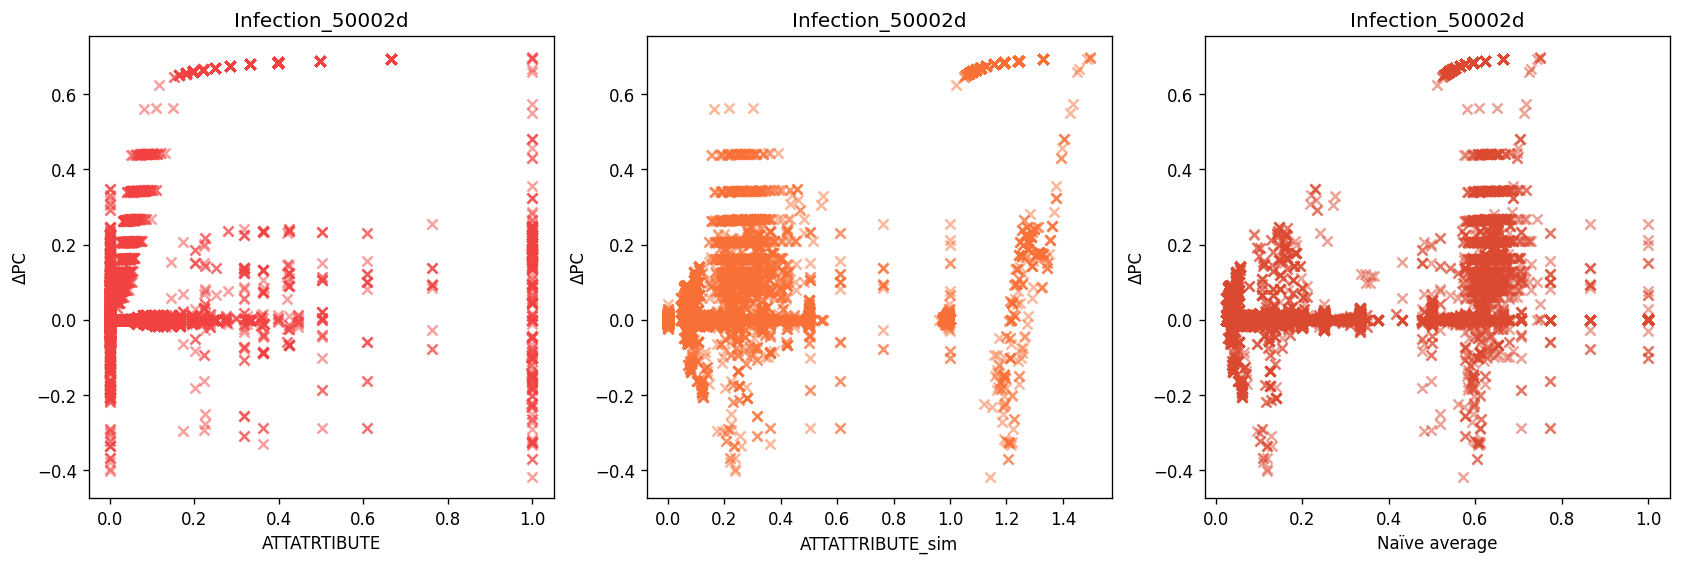

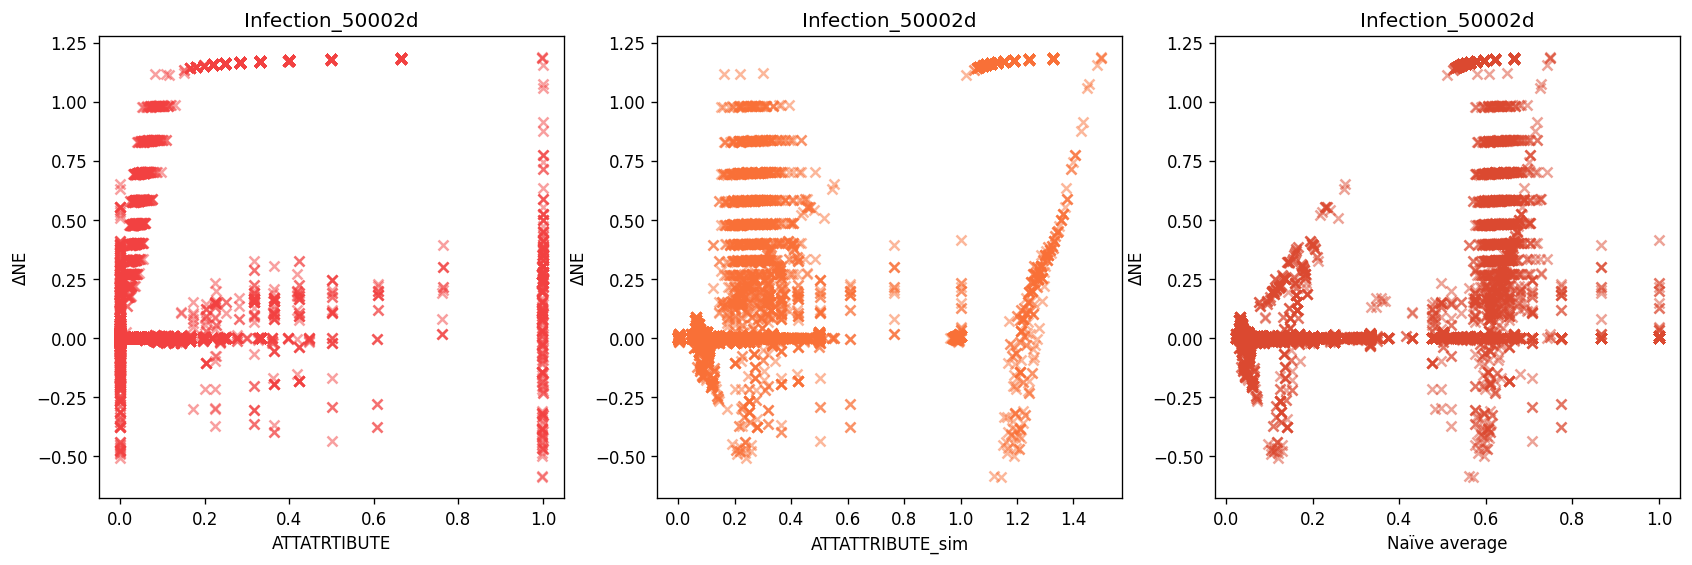

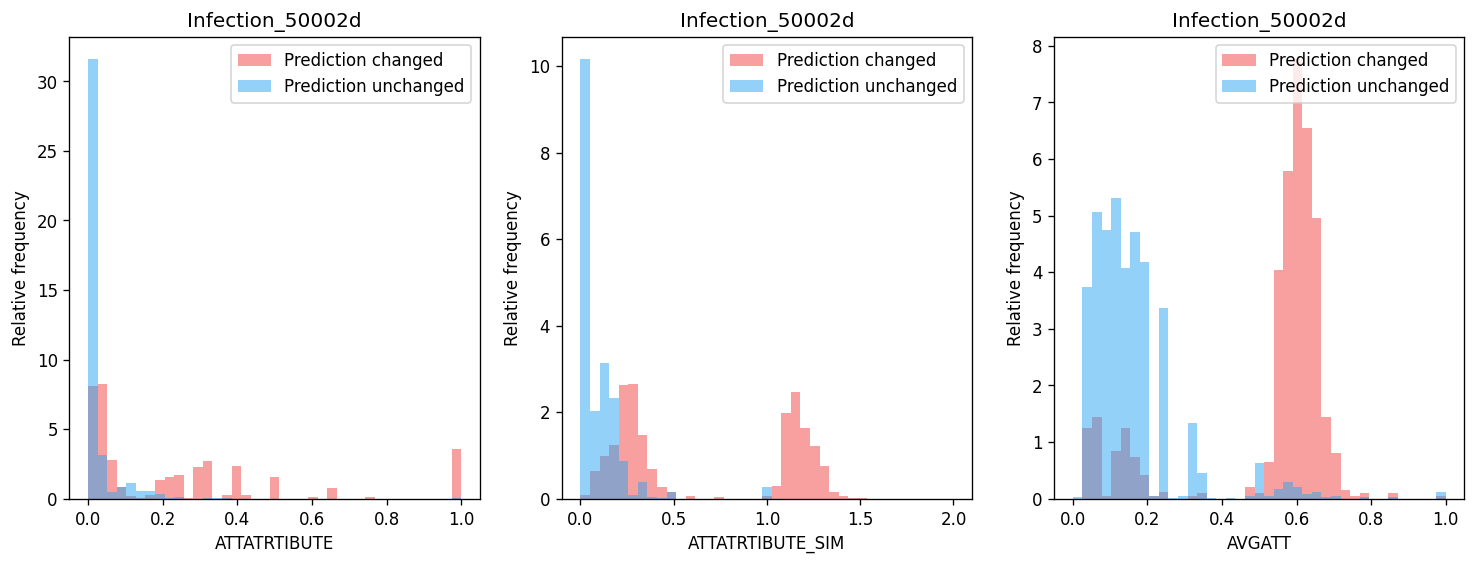

In [99]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Flag to whether print statistics in the figure
PRINT_CORRELATION_COEFFICIENT = False

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
# Scatter plot with alpha=0.5, color #f24141
axs[0].scatter(
    attattribute_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, pred_prob_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #F97037
axs[1].scatter(
    attattribute_sim_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, pred_prob_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #DB4930
axs[2].scatter(
    avgatt_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, pred_prob_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Plot a similar graph but use entropy instead of prediction difference
# Set the figure size to (17, 5)
# Also show the correlation coefficient for each cases inside the corresponding subplot

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
axs[0].scatter(
    attattribute_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, entropy_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[1].scatter(
    attattribute_sim_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, entropy_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[2].scatter(
    avgatt_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, entropy_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Also, plot the data in pred_list_masked_bool (list of 0 and 1s) as a histogram
# For example, we can divide attattribute_list into two groups:
# 1. pred_list_masked_bool = 1
# 2. pred_list_masked_bool = 0
# Then, we can plot the histogram of the two groups in the same plot
# Adjust the alpha value to make the two histograms distinguishable
# The x-axis is the attribute value, and the y-axis is the frequency
# The title of the plot is still the dataset name
# Like above, we can also plot the histogram of the two groups in the same plot
# Do it for all three attattribute_list, attattribute_sim_list, and avgatt_list

# First get the max value of the three lists
max_attattribute_list = max(attattribute_list).ceil()
max_attattribute_sim_list = max(attattribute_sim_list).ceil()
max_avgatt_list = max(avgatt_list).ceil()

# Make two masking tensors from pred_list_masked_bool that are complementary
mask_remained = torch.logical_not(pred_list_masked_bool)
mask_flipped = pred_list_masked_bool.bool()

# Make the bins used for the histogram
bins_attattribute = torch.linspace(0, max_attattribute_list, 40)
bins_attattribute_sim = torch.linspace(0, max_attattribute_sim_list, 40)
bins_avgatt = torch.linspace(0, max_avgatt_list, 40)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
axs[0].hist(attattribute_list[mask_flipped], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#F24141",
            label='Prediction changed')
axs[0].hist(attattribute_list[mask_remained], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#29A5F2",
            label='Prediction unchanged')
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("Relative frequency")

axs[1].hist(attattribute_sim_list[mask_flipped], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[1].hist(attattribute_sim_list[mask_remained], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATRTIBUTE_SIM")
axs[1].set_ylabel("Relative frequency")

axs[2].hist(avgatt_list[mask_flipped], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[2].hist(avgatt_list[mask_remained], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("AVGATT")
axs[2].set_ylabel("Relative frequency")

# Add the legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

In [7]:
# Statistical testing with Kendall's Tau and Spearman's Rho, Pearson's Rho
# Also include the ROC AUC score between each attribution and the decision change in pred_list_masked_bool
# Kendall's Tau is a non-parametric test for the strength of association between two variables
# Spearman's Rho is a non-parametric test for the strength of monotonic association between two variables
from scipy.stats import kendalltau, spearmanr, pearsonr
from sklearn.metrics import roc_auc_score

"""
    Compare...
    1. pred_prob_list_masked_float vs. attattribute_list
    2. pred_prob_list_masked_float vs. attattribute_sim_list
    3. pred_prob_list_masked_float vs. avgatt_list
    4. entropy_list_masked_float vs. attattribute_list
    5. entropy_list_masked_float vs. attattribute_sim_list
    6. entropy_list_masked_float vs. avgatt_list
    7. ROC AUC score between each attribution and the decision change in pred_list_masked_bool
"""
# Also include a random baseline
random_attr = torch.rand(pred_prob_list_masked_float.shape)

random_attr_kendall = kendalltau(pred_prob_list_masked_float, random_attr)
random_attr_spearman = spearmanr(pred_prob_list_masked_float, random_attr)
random_attr_pearson = pearsonr(pred_prob_list_masked_float, random_attr)
random_attr_roc_auc = roc_auc_score(pred_list_masked_bool, random_attr)

# Print results
print("RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{random_attr_kendall[0]:.4f}, {random_attr_spearman[0]:.4f}, {random_attr_pearson[0]:.4f}")
print("RANDOM vs. Δprob: ROC AUC")
print(f"{random_attr_roc_auc:.4f}")


attattribute_prob_kendall = kendalltau(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_spearman = spearmanr(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_pearson = pearsonr(pred_prob_list_masked_float, attattribute_list)

attattribute_sim_prob_kendall = kendalltau(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_spearman = spearmanr(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_pearson = pearsonr(
    pred_prob_list_masked_float, attattribute_sim_list
)

avgatt_prob_kendall = kendalltau(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_spearman = spearmanr(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_pearson = pearsonr(pred_prob_list_masked_float, avgatt_list)

attattribute_entropy_kendall = kendalltau(entropy_list_masked_float, attattribute_list)
attattribute_entropy_spearman = spearmanr(entropy_list_masked_float, attattribute_list)
attattribute_entropy_pearson = pearsonr(entropy_list_masked_float, attattribute_list)

attattribute_sim_entropy_kendall = kendalltau(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_spearman = spearmanr(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_pearson = pearsonr(
    entropy_list_masked_float, attattribute_sim_list
)

avgatt_entropy_kendall = kendalltau(entropy_list_masked_float, avgatt_list)
avgatt_entropy_spearman = spearmanr(entropy_list_masked_float, avgatt_list)
avgatt_entropy_pearson = pearsonr(entropy_list_masked_float, avgatt_list)


attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list / attattribute_list.max())
attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list / attattribute_sim_list.max())
# attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list)
# attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list)
avgatt_roc_auc = roc_auc_score(pred_list_masked_bool, avgatt_list)

# Print results
print("ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_prob_kendall[0]:.4f}, {attattribute_prob_spearman[0]:.4f}, {attattribute_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_prob_kendall[0]:.4f}, {attattribute_sim_prob_spearman[0]:.4f}, {attattribute_sim_prob_pearson[0]:.4f}")
print("AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_prob_kendall[0]:.4f}, {avgatt_prob_spearman[0]:.4f}, {avgatt_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_entropy_kendall[0]:.4f}, {attattribute_entropy_spearman[0]:.4f}, {attattribute_entropy_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_entropy_kendall[0]:.4f}, {attattribute_sim_entropy_spearman[0]:.4f}, {attattribute_sim_entropy_pearson[0]:.4f}")
print("AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_entropy_kendall[0]:.4f}, {avgatt_entropy_spearman[0]:.4f}, {avgatt_entropy_pearson[0]:.4f}")
print("ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT")
print(f"{attattribute_roc_auc:.4f}, {attattribute_sim_roc_auc:.4f}, {avgatt_roc_auc:.4f}")

RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0040, 0.0056, -0.0027
RANDOM vs. Δprob: ROC AUC
0.4966
ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2286, 0.2646, 0.4200
ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.3462, 0.4103, 0.5792
AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2355, 0.3052, 0.3876
ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2223, 0.2559, 0.4058
ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.3874, 0.4618, 0.5675
AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2369, 0.3067, 0.4254
ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT
0.8739, 0.9337, 0.8836


Now for the Infection_50003d.pt

In [8]:
import torch

dataset_name = "Infection_50003d"
model_name = "GAT_infection_3L1H"

device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load(f"/workspace/{dataset_name}.pt").to(device)
# Load the trained model locally (for reproduction)
model = torch.load(f"/workspace/{model_name}.pt").to(device)
model.eval()

with torch.no_grad():
    att = model.att

# Load experiments from local

attattribute_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt"
)
attattribute_sim_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt"
)
avgatt_list = torch.load(f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt")
pred_list_masked_bool = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt"
)
pred_prob_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt"
)
entropy_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt"
)

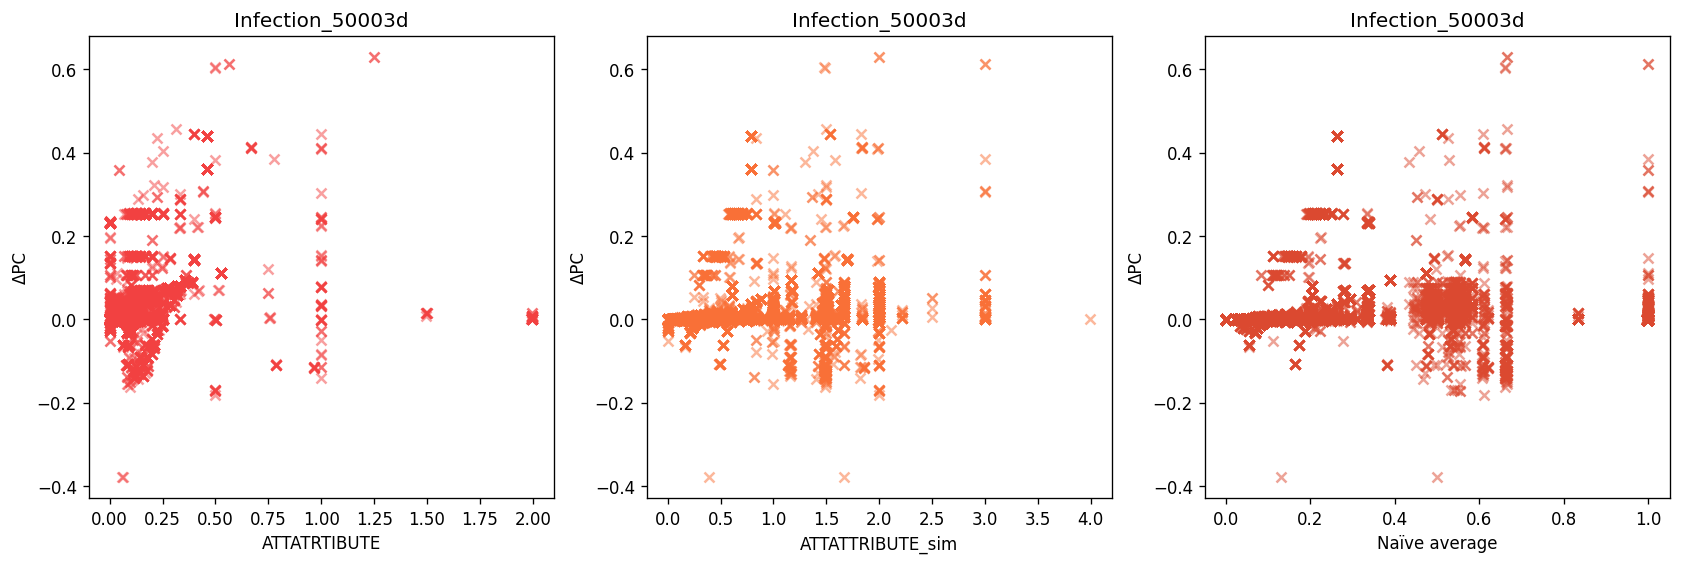

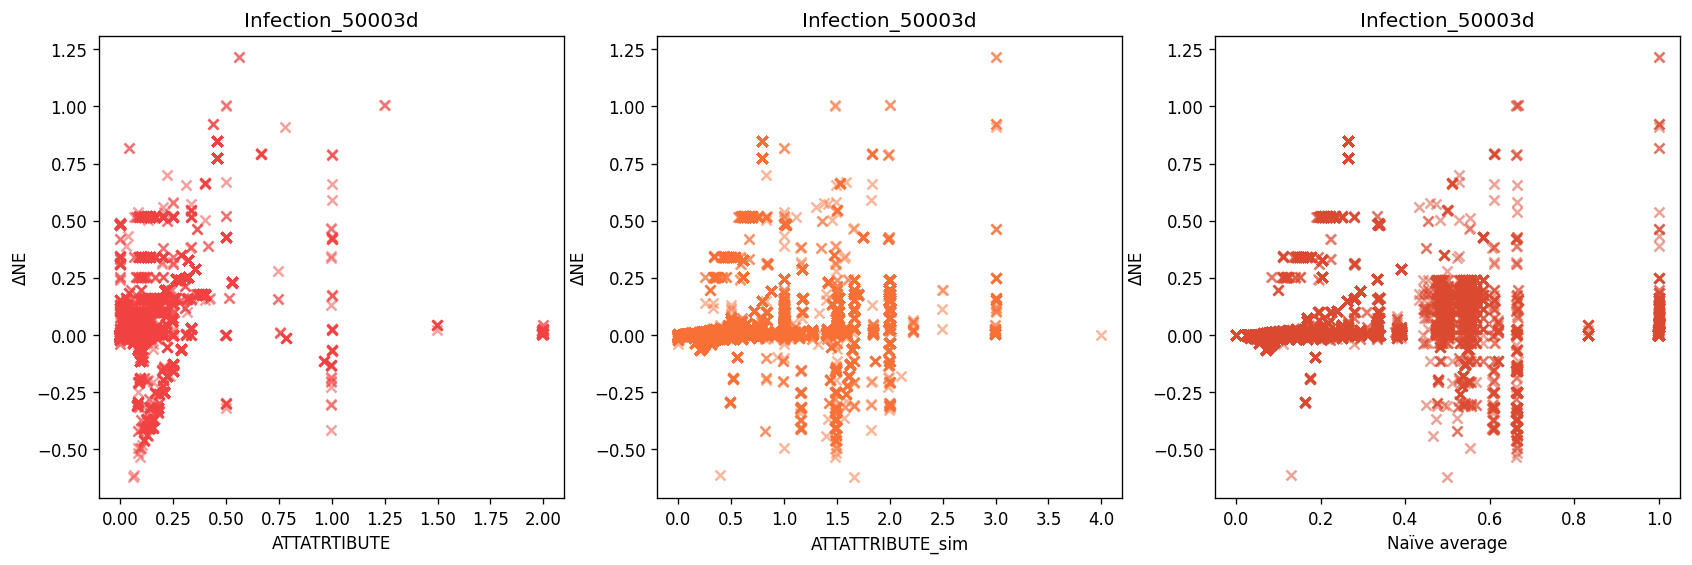

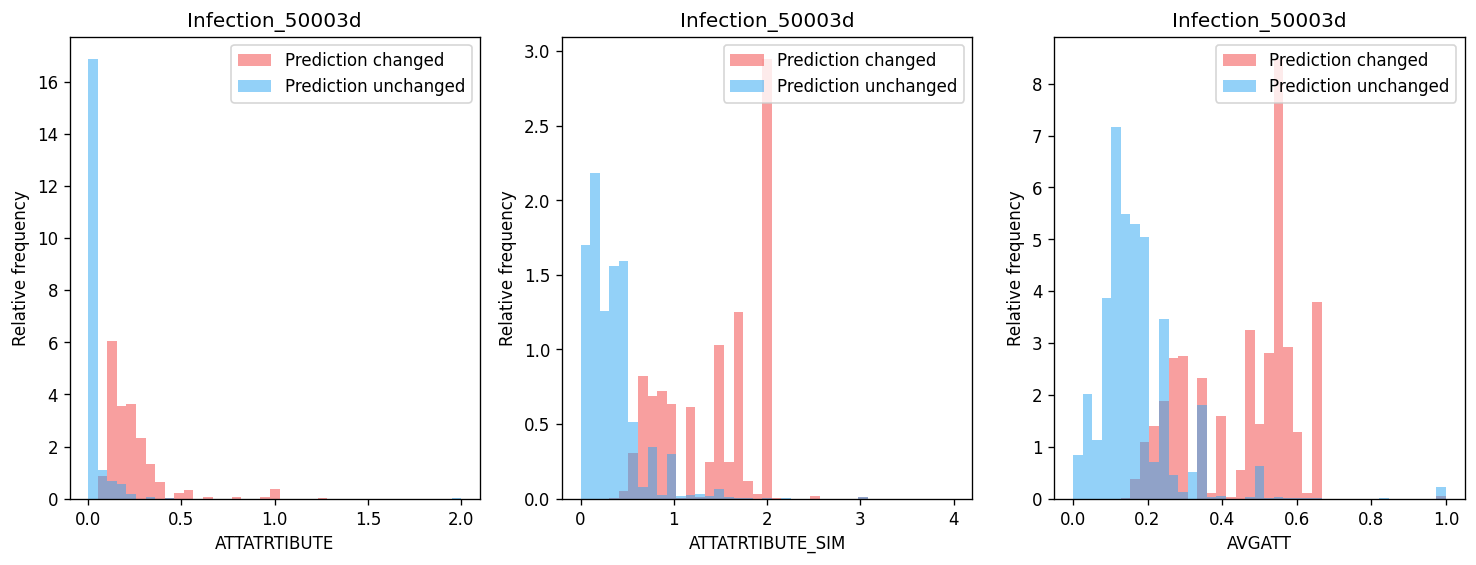

In [102]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Flag to whether print statistics in the figure
PRINT_CORRELATION_COEFFICIENT = False

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
# Scatter plot with alpha=0.5, color #f24141
axs[0].scatter(
    attattribute_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, pred_prob_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #F97037
axs[1].scatter(
    attattribute_sim_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, pred_prob_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #DB4930
axs[2].scatter(
    avgatt_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, pred_prob_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Plot a similar graph but use entropy instead of prediction difference
# Set the figure size to (17, 5)
# Also show the correlation coefficient for each cases inside the corresponding subplot

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
axs[0].scatter(
    attattribute_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, entropy_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[1].scatter(
    attattribute_sim_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, entropy_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[2].scatter(
    avgatt_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, entropy_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Also, plot the data in pred_list_masked_bool (list of 0 and 1s) as a histogram
# For example, we can divide attattribute_list into two groups:
# 1. pred_list_masked_bool = 1
# 2. pred_list_masked_bool = 0
# Then, we can plot the histogram of the two groups in the same plot
# Adjust the alpha value to make the two histograms distinguishable
# The x-axis is the attribute value, and the y-axis is the frequency
# The title of the plot is still the dataset name
# Like above, we can also plot the histogram of the two groups in the same plot
# Do it for all three attattribute_list, attattribute_sim_list, and avgatt_list

# First get the max value of the three lists
max_attattribute_list = max(attattribute_list).ceil()
max_attattribute_sim_list = max(attattribute_sim_list).ceil()
max_avgatt_list = max(avgatt_list).ceil()

# Make two masking tensors from pred_list_masked_bool that are complementary
mask_remained = torch.logical_not(pred_list_masked_bool)
mask_flipped = pred_list_masked_bool.bool()

# Make the bins used for the histogram
bins_attattribute = torch.linspace(0, max_attattribute_list, 40)
bins_attattribute_sim = torch.linspace(0, max_attattribute_sim_list, 40)
bins_avgatt = torch.linspace(0, max_avgatt_list, 40)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
axs[0].hist(attattribute_list[mask_flipped], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#F24141",
            label='Prediction changed')
axs[0].hist(attattribute_list[mask_remained], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#29A5F2",
            label='Prediction unchanged')
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("Relative frequency")

axs[1].hist(attattribute_sim_list[mask_flipped], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[1].hist(attattribute_sim_list[mask_remained], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATRTIBUTE_SIM")
axs[1].set_ylabel("Relative frequency")

axs[2].hist(avgatt_list[mask_flipped], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[2].hist(avgatt_list[mask_remained], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("AVGATT")
axs[2].set_ylabel("Relative frequency")

# Add the legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

In [9]:
# Statistical testing with Kendall's Tau and Spearman's Rho, Pearson's Rho
# Also include the ROC AUC score between each attribution and the decision change in pred_list_masked_bool
# Kendall's Tau is a non-parametric test for the strength of association between two variables
# Spearman's Rho is a non-parametric test for the strength of monotonic association between two variables
from scipy.stats import kendalltau, spearmanr, pearsonr
from sklearn.metrics import roc_auc_score

"""
    Compare...
    1. pred_prob_list_masked_float vs. attattribute_list
    2. pred_prob_list_masked_float vs. attattribute_sim_list
    3. pred_prob_list_masked_float vs. avgatt_list
    4. entropy_list_masked_float vs. attattribute_list
    5. entropy_list_masked_float vs. attattribute_sim_list
    6. entropy_list_masked_float vs. avgatt_list
    7. ROC AUC score between each attribution and the decision change in pred_list_masked_bool
"""
# Also include a random baseline
random_attr = torch.rand(pred_prob_list_masked_float.shape)

random_attr_kendall = kendalltau(pred_prob_list_masked_float, random_attr)
random_attr_spearman = spearmanr(pred_prob_list_masked_float, random_attr)
random_attr_pearson = pearsonr(pred_prob_list_masked_float, random_attr)
random_attr_roc_auc = roc_auc_score(pred_list_masked_bool, random_attr)

# Print results
print("RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{random_attr_kendall[0]:.4f}, {random_attr_spearman[0]:.4f}, {random_attr_pearson[0]:.4f}")
print("RANDOM vs. Δprob: ROC AUC")
print(f"{random_attr_roc_auc:.4f}")


attattribute_prob_kendall = kendalltau(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_spearman = spearmanr(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_pearson = pearsonr(pred_prob_list_masked_float, attattribute_list)

attattribute_sim_prob_kendall = kendalltau(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_spearman = spearmanr(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_pearson = pearsonr(
    pred_prob_list_masked_float, attattribute_sim_list
)

avgatt_prob_kendall = kendalltau(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_spearman = spearmanr(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_pearson = pearsonr(pred_prob_list_masked_float, avgatt_list)

attattribute_entropy_kendall = kendalltau(entropy_list_masked_float, attattribute_list)
attattribute_entropy_spearman = spearmanr(entropy_list_masked_float, attattribute_list)
attattribute_entropy_pearson = pearsonr(entropy_list_masked_float, attattribute_list)

attattribute_sim_entropy_kendall = kendalltau(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_spearman = spearmanr(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_pearson = pearsonr(
    entropy_list_masked_float, attattribute_sim_list
)

avgatt_entropy_kendall = kendalltau(entropy_list_masked_float, avgatt_list)
avgatt_entropy_spearman = spearmanr(entropy_list_masked_float, avgatt_list)
avgatt_entropy_pearson = pearsonr(entropy_list_masked_float, avgatt_list)


attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list / attattribute_list.max())
attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list / attattribute_sim_list.max())
# attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list)
# attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list)
avgatt_roc_auc = roc_auc_score(pred_list_masked_bool, avgatt_list)

# Print results
print("ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_prob_kendall[0]:.4f}, {attattribute_prob_spearman[0]:.4f}, {attattribute_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_prob_kendall[0]:.4f}, {attattribute_sim_prob_spearman[0]:.4f}, {attattribute_sim_prob_pearson[0]:.4f}")
print("AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_prob_kendall[0]:.4f}, {avgatt_prob_spearman[0]:.4f}, {avgatt_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_entropy_kendall[0]:.4f}, {attattribute_entropy_spearman[0]:.4f}, {attattribute_entropy_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_entropy_kendall[0]:.4f}, {attattribute_sim_entropy_spearman[0]:.4f}, {attattribute_sim_entropy_pearson[0]:.4f}")
print("AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_entropy_kendall[0]:.4f}, {avgatt_entropy_spearman[0]:.4f}, {avgatt_entropy_pearson[0]:.4f}")
print("ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT")
print(f"{attattribute_roc_auc:.4f}, {attattribute_sim_roc_auc:.4f}, {avgatt_roc_auc:.4f}")

RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
-0.0018, -0.0028, 0.0039
RANDOM vs. Δprob: ROC AUC
0.4928
ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.3177, 0.4053, 0.3615
ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.3708, 0.5254, 0.2567
AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2132, 0.3044, 0.1682
ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.3496, 0.4478, 0.3820
ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.3757, 0.5325, 0.2837
AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.2018, 0.2897, 0.1728
ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT
0.9706, 0.9747, 0.9493
